In [1]:
import gc
import os
import cv2
import torch
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import *
from torchvision.models import resnet152
from torchvision.transforms import transforms
from tab_transformer_pytorch import TabTransformer

warnings.filterwarnings('ignore')

In [2]:
Deep_features = []
root = 'C:\\Users\\Eurus\\Desktop\\Data\\images'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Load the ResNet-152 model
resnet = resnet152(pretrained=False)

In [3]:
resnet.to(device)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
# Transformation for preprocessing
preprocess = transforms.Compose([
    transforms.Resize((540, 540)),
    transforms.ToTensor()
])

In [5]:
def feature_extractor(root):
    # Iterate over the images
    for idx in tqdm(os.listdir(root)):
        
        # Read the image
        path = os.path.join(root, idx)
        img = Image.open(path)
        
        # Preprocess and Normalize the images
        img_tensor = preprocess(img).div(255.0).unsqueeze(0).to(device)
        
        # Extract features using ResNet-152
        with torch.no_grad():
            features = resnet(img_tensor)
            
        # Flatten the features
        features = features.flatten().cpu().numpy()
        
        # Store the features in the dictionary
        if "T" in idx:
            Deep_features.append({'Label':'T','Features':features})
        elif "N" in idx:
            Deep_features.append({'Label':'N','Features':features})
        else:
            print("error!")
            
    
    return Deep_features
        

In [6]:
Train_features = feature_extractor(root)

100%|████████████████████████████████████████████████████████████████████████████| 13832/13832 [19:41<00:00, 11.70it/s]


In [7]:
# shuffle the data
random.shuffle(Train_features)

In [8]:
df = pd.DataFrame()

# Iterate over the list of dictionaries
for idx, d in enumerate(Train_features):
    # Extract the label and features from each dictionary
    label = d['Label']
    features = d['Features']
    
    # Create a dictionary for the row data
    row_data = {'Label': label}
    
    # Add the features as columns to the row dictionary
    for i, value in enumerate(features):
        column_name = f'F_{i}'
        row_data[column_name] = value
    
    # Append the row to the DataFrame
    df = df.append(row_data, ignore_index=True)


In [9]:
del Train_features

In [10]:
# y = df['Label']
# y.tail(10)

In [11]:
# df.drop(['Label'], axis=1, inplace=True)
# df.head()

In [12]:
df.head(10)

,Label,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_990,F_991,F_992,F_993,F_994,F_995,F_996,F_997,F_998,F_999
0,T,-26117.371094,16035.014648,23200.470703,89030.054688,6920.775879,27745.660156,23547.400391,16465.283203,-3545.567139,...,-6249.820801,-15924.910156,26788.421875,11953.225586,-8349.807617,-18170.203125,-36372.894531,14860.389648,-39178.921875,32396.042969
1,N,-28758.693359,17711.962891,26005.017578,99456.992188,8160.221680,30547.761719,26281.109375,17014.966797,-4566.664062,...,-6760.362793,-17011.949219,30259.949219,12206.327148,-6656.063477,-19835.560547,-40315.402344,16146.525391,-44481.503906,36298.523438
2,N,-29843.152344,20131.388672,28647.535156,108756.875000,9531.335938,34743.542969,29151.474609,19297.904297,-6841.328613,...,-7968.353516,-19226.185547,33364.074219,14850.177734,-7539.659180,-22248.994141,-43673.722656,16917.091797,-50033.960938,41113.332031
3,N,-28196.707031,17159.478516,25122.203125,96480.710938,7427.877441,29677.033203,25499.152344,16824.443359,-3998.261230,...,-6862.132812,-16733.751953,29621.318359,12131.085938,-7074.797852,-19496.882812,-39266.730469,15840.695312,-42729.332031,35179.472656
4,N,-28755.050781,17740.638672,26238.470703,99156.945312,8496.038086,30569.378906,26236.097656,16893.580078,-4476.977539,...,-7023.131836,-17585.685547,30447.117188,12043.545898,-6773.620605,-19447.132812,-39879.652344,15472.299805,-44748.925781,36573.789062
5,T,-26173.267578,16646.294922,23722.318359,90715.500000,6670.963867,27633.136719,24758.476562,15721.434570,-4840.067871,...,-6798.707031,-15374.402344,27655.923828,11825.142578,-7016.944336,-18535.449219,-36998.957031,14650.634766,-40662.253906,33496.859375
6,N,-20168.728516,11004.564453,18483.353516,66474.000000,4721.870117,20355.218750,18207.257812,11991.157227,-3341.320557,...,-4055.068604,-11059.985352,19755.267578,8018.763184,-6320.018066,-13456.565430,-26660.277344,10456.225586,-29161.089844,23548.890625
7,N,-29550.242188,18637.216797,27031.777344,103560.132812,8286.209961,32280.167969,27332.480469,18449.322266,-5032.696289,...,-7372.789062,-18316.460938,31902.841797,13726.759766,-7904.011719,-21272.355469,-41775.867188,16772.494141,-46335.886719,38189.621094
8,N,-31236.697266,19800.212891,28513.167969,109504.062500,9044.779297,34161.523438,28754.023438,19358.419922,-5449.770508,...,-7437.770508,-19482.650391,33564.578125,14248.279297,-7882.583984,-22130.566406,-43873.085938,17505.720703,-49657.367188,40538.656250
9,N,-16236.888672,8397.816406,14776.301758,52461.093750,4040.650879,16244.646484,14135.338867,9434.991211,-2325.140869,...,-2919.756104,-9073.406250,15330.319336,6152.280762,-5408.627441,-10230.069336,-21102.769531,7953.299805,-22735.093750,18124.738281


In [13]:
# One hot encoding the Labels
for row in tqdm(range(len(df))):
    if df.loc[row,'Label'] == "N":
        df.loc[row,'Label'] = 0
        
    elif df.loc[row,'Label'] == "T":
        df.loc[row,'Label'] = 1

df.head(10)

100%|█████████████████████████████████████████████████████████████████████████| 13832/13832 [00:00<00:00, 14469.77it/s]


,Label,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_990,F_991,F_992,F_993,F_994,F_995,F_996,F_997,F_998,F_999
0,1,-26117.371094,16035.014648,23200.470703,89030.054688,6920.775879,27745.660156,23547.400391,16465.283203,-3545.567139,...,-6249.820801,-15924.910156,26788.421875,11953.225586,-8349.807617,-18170.203125,-36372.894531,14860.389648,-39178.921875,32396.042969
1,0,-28758.693359,17711.962891,26005.017578,99456.992188,8160.221680,30547.761719,26281.109375,17014.966797,-4566.664062,...,-6760.362793,-17011.949219,30259.949219,12206.327148,-6656.063477,-19835.560547,-40315.402344,16146.525391,-44481.503906,36298.523438
2,0,-29843.152344,20131.388672,28647.535156,108756.875000,9531.335938,34743.542969,29151.474609,19297.904297,-6841.328613,...,-7968.353516,-19226.185547,33364.074219,14850.177734,-7539.659180,-22248.994141,-43673.722656,16917.091797,-50033.960938,41113.332031
3,0,-28196.707031,17159.478516,25122.203125,96480.710938,7427.877441,29677.033203,25499.152344,16824.443359,-3998.261230,...,-6862.132812,-16733.751953,29621.318359,12131.085938,-7074.797852,-19496.882812,-39266.730469,15840.695312,-42729.332031,35179.472656
4,0,-28755.050781,17740.638672,26238.470703,99156.945312,8496.038086,30569.378906,26236.097656,16893.580078,-4476.977539,...,-7023.131836,-17585.685547,30447.117188,12043.545898,-6773.620605,-19447.132812,-39879.652344,15472.299805,-44748.925781,36573.789062
5,1,-26173.267578,16646.294922,23722.318359,90715.500000,6670.963867,27633.136719,24758.476562,15721.434570,-4840.067871,...,-6798.707031,-15374.402344,27655.923828,11825.142578,-7016.944336,-18535.449219,-36998.957031,14650.634766,-40662.253906,33496.859375
6,0,-20168.728516,11004.564453,18483.353516,66474.000000,4721.870117,20355.218750,18207.257812,11991.157227,-3341.320557,...,-4055.068604,-11059.985352,19755.267578,8018.763184,-6320.018066,-13456.565430,-26660.277344,10456.225586,-29161.089844,23548.890625
7,0,-29550.242188,18637.216797,27031.777344,103560.132812,8286.209961,32280.167969,27332.480469,18449.322266,-5032.696289,...,-7372.789062,-18316.460938,31902.841797,13726.759766,-7904.011719,-21272.355469,-41775.867188,16772.494141,-46335.886719,38189.621094
8,0,-31236.697266,19800.212891,28513.167969,109504.062500,9044.779297,34161.523438,28754.023438,19358.419922,-5449.770508,...,-7437.770508,-19482.650391,33564.578125,14248.279297,-7882.583984,-22130.566406,-43873.085938,17505.720703,-49657.367188,40538.656250
9,0,-16236.888672,8397.816406,14776.301758,52461.093750,4040.650879,16244.646484,14135.338867,9434.991211,-2325.140869,...,-2919.756104,-9073.406250,15330.319336,6152.280762,-5408.627441,-10230.069336,-21102.769531,7953.299805,-22735.093750,18124.738281


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13832 entries, 0 to 13831
Columns: 1001 entries, Label to F_999
dtypes: float32(1000), object(1)
memory usage: 52.9+ MB


In [15]:
df['Label'] = df['Label'].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13832 entries, 0 to 13831
Columns: 1001 entries, Label to F_999
dtypes: float32(1001)
memory usage: 52.8 MB


In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df['Label'], test_size=0.2, random_state=42, stratify=df['Label'])

In [18]:
del df 
gc.collect()

0

In [151]:
model = TabTransformer(
    num_continuous=1000,                 # Number of continuous features (excluding the label column)
    dim=32,                             # Dimension, you can modify it as per your needs
    dim_out=1,                           # Number of output dimensions (e.g., for binary prediction)
    depth=6,                             # Depth, adjust it based on your dataset complexity
    heads=8,                             # Number of attention heads
    attn_dropout=0.1,                    # Post-attention dropout
    ff_dropout=0.3,                      # Feed-forward dropout
    mlp_hidden_mults=(12, 6),             # Relative multiples of each hidden dimension of the last MLP to logits
    mlp_act=None,                        # Activation for the final MLP
)

In [152]:
# Train_labels = torch.tensor(y_train.values) 
# Test_labels = torch.tensor(y_test.values) 

# Train_features = torch.tensor(X_train.values) 
# Test_features = torch.tensor(X_test.values) 

In [153]:
loss_fn = nn.BCELoss()

In [154]:
optimizer = torch.optim.Adam(model.parameters() , lr=0.001)

In [155]:
num_epochs = 250
batch_size = 16
plot_points = []

for epoch in range(num_epochs):
    # Set model mode to train
    model.train() 
    for i in range(0, len(y_train), batch_size):
        
        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer
        optimizer.zero_grad()
        
        # Create mini-batches of torch tensors to train more efficiently
        batch_features = X_train[i:i+batch_size]
        batch_features = torch.tensor(batch_features.values, dtype=torch.float32)
        
        batch_labels = y_train[i:i+batch_size]
        batch_labels = torch.tensor(batch_labels.values, dtype=torch.float32)
#         print(f"batch labels: {batch_labels}") ------------------- > "Debugging"
        batch_labels = batch_labels.unsqueeze(1)  
        
        "Forward Pass"
        output = model(batch_features)
#         print(f"batch output: {output}") ------------------- > "Debugging"
        output = torch.sigmoid(output)
#         print(f"batch output: {output}") ------------------- > "Debugging"
        loss = loss_fn(output, batch_labels)
        
        "Backpropagation"
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True
        loss.backward()
        
        # Update the weights
        optimizer.step()
    
    # Set model mode to test
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
    model.eval()
    
    # Do not calculate gradients (Evaluation)
    with torch.no_grad():
        Test_output = model(X_test_tensor)
        Test_output = torch.sigmoid(Test_output)
        
        # Reshape the y_test to prevent Error: (Using a target size "" that is different to the input size "" is deprecated.)
        y_test_reshaped = y_test_tensor.view(Test_output.shape)
        val_loss = loss_fn(Test_output, y_test_reshaped)

        
        # Convert the predicted probabilities to binary predictions (0 or 1)
        binary_predictions = (Test_output >= 0.5).float()

        # Calculate the number of true positives, false negatives, and false positives
        true_positives = ((binary_predictions == 1.0) & (y_test_reshaped == 1.0)).sum().item()
        false_negatives = ((binary_predictions == 0.0) & (y_test_reshaped == 1.0)).sum().item()
        false_positives = ((binary_predictions == 1.0) & (y_test_reshaped == 0.0)).sum().item()

        # Calculate recall and precision
        if true_positives == 0 and false_negatives == 0:
            recall = 0.0
            precision = 0.0
            f1_score = 0.0
            
        if true_positives == 0 and false_positives == 0:
            recall = 0.0
            precision = 0.0
            f1_score = 0.0
            
        else:
            recall = true_positives / (true_positives + false_negatives)
            precision = true_positives / (true_positives + false_positives)
            f1_score = 2*(recall*precision)/(recall+precision)
        
    # Print the loss for this epoch
    plot_points.append({"epoch":epoch, "recall":recall, "precision":precision, "f1_score":f1_score, "validation_loss":val_loss.item()})
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1_score: {f1_score:.4f}")

Epoch 1/250: Train Loss: 0.1219, Val Loss: 0.3037, Recall: 0.0000, Precision: 0.0000, F1_score: 0.0000
Epoch 2/250: Train Loss: 0.1374, Val Loss: 0.3041, Recall: 0.0000, Precision: 0.0000, F1_score: 0.0000
Epoch 3/250: Train Loss: 0.1468, Val Loss: 0.3022, Recall: 0.0000, Precision: 0.0000, F1_score: 0.0000
Epoch 4/250: Train Loss: 0.1291, Val Loss: 0.2972, Recall: 0.0000, Precision: 0.0000, F1_score: 0.0000
Epoch 5/250: Train Loss: 0.1530, Val Loss: 0.2952, Recall: 0.0000, Precision: 0.0000, F1_score: 0.0000
Epoch 6/250: Train Loss: 0.1495, Val Loss: 0.2885, Recall: 0.0000, Precision: 0.0000, F1_score: 0.0000
Epoch 7/250: Train Loss: 0.1492, Val Loss: 0.2867, Recall: 0.0000, Precision: 0.0000, F1_score: 0.0000
Epoch 8/250: Train Loss: 0.1469, Val Loss: 0.2842, Recall: 0.0000, Precision: 0.0000, F1_score: 0.0000
Epoch 9/250: Train Loss: 0.1479, Val Loss: 0.2852, Recall: 0.0000, Precision: 0.0000, F1_score: 0.0000
Epoch 10/250: Train Loss: 0.1457, Val Loss: 0.2821, Recall: 0.0000, Preci

Epoch 80/250: Train Loss: 0.0166, Val Loss: 0.1523, Recall: 0.5748, Precision: 0.8156, F1_score: 0.6744
Epoch 81/250: Train Loss: 0.0331, Val Loss: 0.1472, Recall: 0.6575, Precision: 0.7990, F1_score: 0.7214
Epoch 82/250: Train Loss: 0.0268, Val Loss: 0.1353, Recall: 0.6496, Precision: 0.8376, F1_score: 0.7317
Epoch 83/250: Train Loss: 0.0346, Val Loss: 0.1605, Recall: 0.6063, Precision: 0.7857, F1_score: 0.6844
Epoch 84/250: Train Loss: 0.0498, Val Loss: 0.1367, Recall: 0.6850, Precision: 0.7838, F1_score: 0.7311
Epoch 85/250: Train Loss: 0.0243, Val Loss: 0.1865, Recall: 0.5866, Precision: 0.7233, F1_score: 0.6478
Epoch 86/250: Train Loss: 0.0261, Val Loss: 0.1339, Recall: 0.6299, Precision: 0.8556, F1_score: 0.7256
Epoch 87/250: Train Loss: 0.0131, Val Loss: 0.1407, Recall: 0.6417, Precision: 0.8490, F1_score: 0.7309
Epoch 88/250: Train Loss: 0.0194, Val Loss: 0.1712, Recall: 0.5709, Precision: 0.7796, F1_score: 0.6591
Epoch 89/250: Train Loss: 0.0200, Val Loss: 0.1419, Recall: 0.64

Epoch 159/250: Train Loss: 1.4929, Val Loss: 0.3850, Recall: 0.5197, Precision: 0.5946, F1_score: 0.5546
Epoch 160/250: Train Loss: 0.0152, Val Loss: 0.1351, Recall: 0.7559, Precision: 0.8649, F1_score: 0.8067
Epoch 161/250: Train Loss: 0.0040, Val Loss: 0.1404, Recall: 0.7362, Precision: 0.8462, F1_score: 0.7874
Epoch 162/250: Train Loss: 0.0105, Val Loss: 0.1200, Recall: 0.7835, Precision: 0.8541, F1_score: 0.8172
Epoch 163/250: Train Loss: 0.0040, Val Loss: 0.1327, Recall: 0.7126, Precision: 0.9188, F1_score: 0.8027
Epoch 164/250: Train Loss: 0.0057, Val Loss: 0.1242, Recall: 0.8110, Precision: 0.8619, F1_score: 0.8357
Epoch 165/250: Train Loss: 0.0071, Val Loss: 0.1359, Recall: 0.7244, Precision: 0.8679, F1_score: 0.7897
Epoch 166/250: Train Loss: 0.0252, Val Loss: 0.1288, Recall: 0.7835, Precision: 0.8728, F1_score: 0.8257
Epoch 167/250: Train Loss: 0.4253, Val Loss: 0.1514, Recall: 0.7244, Precision: 0.8326, F1_score: 0.7747
Epoch 168/250: Train Loss: 0.0021, Val Loss: 0.1410, Re

Epoch 238/250: Train Loss: 0.0003, Val Loss: 0.1487, Recall: 0.7480, Precision: 0.9596, F1_score: 0.8407
Epoch 239/250: Train Loss: 0.0026, Val Loss: 0.1724, Recall: 0.7323, Precision: 0.8611, F1_score: 0.7915
Epoch 240/250: Train Loss: 0.0021, Val Loss: 0.2641, Recall: 0.7362, Precision: 0.7857, F1_score: 0.7602
Epoch 241/250: Train Loss: 0.0008, Val Loss: 0.1418, Recall: 0.7913, Precision: 0.8816, F1_score: 0.8340
Epoch 242/250: Train Loss: 0.0008, Val Loss: 0.1262, Recall: 0.7756, Precision: 0.9752, F1_score: 0.8640
Epoch 243/250: Train Loss: 0.0004, Val Loss: 0.1456, Recall: 0.7402, Precision: 0.9447, F1_score: 0.8300
Epoch 244/250: Train Loss: 0.0169, Val Loss: 0.1861, Recall: 0.7598, Precision: 0.7338, F1_score: 0.7466
Epoch 245/250: Train Loss: 0.0182, Val Loss: 0.1413, Recall: 0.8150, Precision: 0.7962, F1_score: 0.8054
Epoch 246/250: Train Loss: 0.0006, Val Loss: 0.1832, Recall: 0.7874, Precision: 0.8969, F1_score: 0.8386
Epoch 247/250: Train Loss: 0.3674, Val Loss: 0.1842, Re

In [156]:
temp_df = pd.DataFrame(plot_points)

In [157]:
# Write it to CSV
temp_df.to_csv("11th_Setting.csv", index=False)

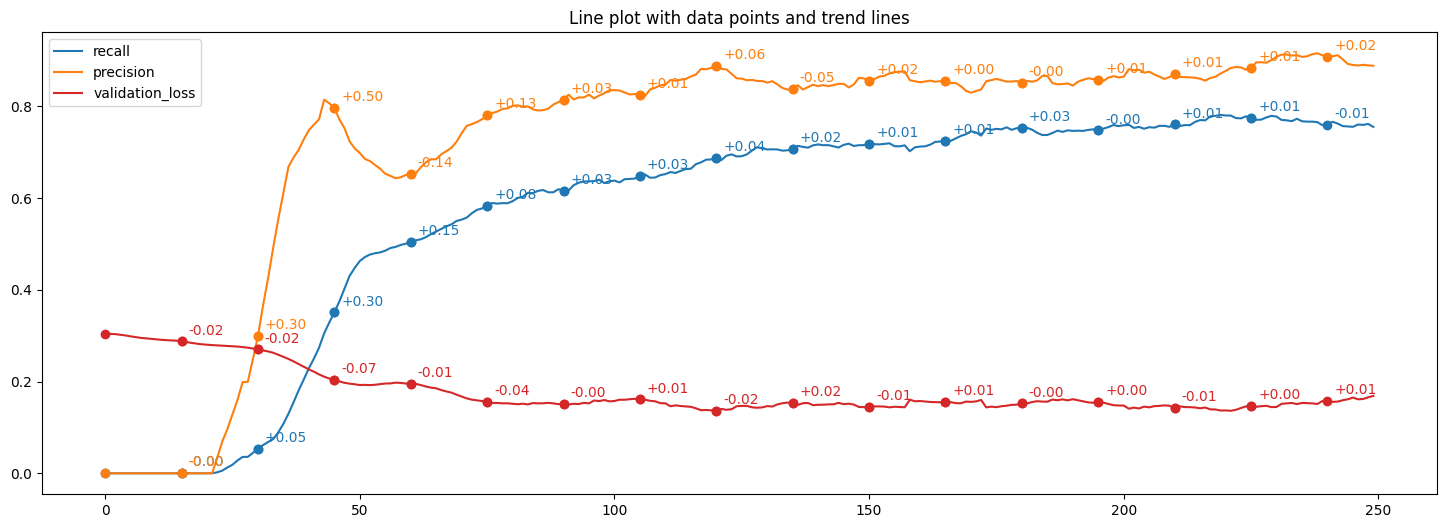

In [158]:
window_size = 15

# Calculate moving average for each metric
temp_df['recall_avg'] = temp_df['recall'].rolling(window_size, min_periods=1).mean()
temp_df['precision_avg'] = temp_df['precision'].rolling(window_size, min_periods=1).mean()
temp_df['validation_loss_avg'] = temp_df['validation_loss'].rolling(window_size, min_periods=1).mean()

# Plot the moving average lines
fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(temp_df['epoch'], temp_df['recall_avg'], color='tab:blue', label='recall')
ax.plot(temp_df['epoch'], temp_df['precision_avg'], color='tab:orange', label='precision')
ax.plot(temp_df['epoch'], temp_df['validation_loss_avg'], color='tab:red', label='validation_loss')

ax.set_title('Line plot with data points and trend lines')
ax.legend()

# Add slope annotations for selected trend lines
for i in range(window_size, len(temp_df), window_size):
    delta_recall = temp_df['recall_avg'][i] - temp_df['recall_avg'][i - window_size]
    delta_precision = temp_df['precision_avg'][i] - temp_df['precision_avg'][i - window_size]
    delta_loss = temp_df['validation_loss_avg'][i] - temp_df['validation_loss_avg'][i - window_size]

    slope_recall = '+' if delta_recall > 0 else '-'
    slope_precision = '+' if delta_precision > 0 else '-'
    slope_loss = '+' if delta_loss > 0 else '-'

    ax.annotate(f'{slope_recall}{abs(delta_recall):.2f}', (temp_df['epoch'][i], temp_df['recall_avg'][i]), xytext=(5, 5),
                textcoords='offset points', color='tab:blue')
    ax.annotate(f'{slope_precision}{abs(delta_precision):.2f}', (temp_df['epoch'][i], temp_df['precision_avg'][i]), xytext=(5, 5),
                textcoords='offset points', color='tab:orange')
    ax.annotate(f'{slope_loss}{abs(delta_loss):.2f}', (temp_df['epoch'][i], temp_df['validation_loss_avg'][i]), xytext=(5, 5),
                textcoords='offset points', color='tab:red')

    ax.plot(temp_df['epoch'][i], temp_df['recall_avg'][i], marker='o', markersize=6, color='tab:blue')
    ax.plot(temp_df['epoch'][i - window_size], temp_df['recall_avg'][i - window_size], marker='o', markersize=6, color='tab:blue')
    ax.plot(temp_df['epoch'][i], temp_df['precision_avg'][i], marker='o', markersize=6, color='tab:orange')
    ax.plot(temp_df['epoch'][i - window_size], temp_df['precision_avg'][i - window_size], marker='o', markersize=6, color='tab:orange')
    ax.plot(temp_df['epoch'][i], temp_df['validation_loss_avg'][i], marker='o', markersize=6, color='tab:red')
    ax.plot(temp_df['epoch'][i - window_size], temp_df['validation_loss_avg'][i - window_size], marker='o', markersize=6, color='tab:red')

plt.show()


In [150]:
del model, temp_df, plot_points
gc.collect()

11508

# Deep into the Visualization

In [160]:
first_setting = pd.read_csv("1st_Setting.csv")
second_setting = pd.read_csv("2nd_Setting.csv")
third_setting = pd.read_csv("3rd_Setting.csv")
fourth_setting = pd.read_csv("4th_Setting.csv")
fifth_setting = pd.read_csv("5th_Setting.csv")
sixth_setting = pd.read_csv("6th_Setting.csv")
seventh_setting = pd.read_csv("7th_Setting.csv")
eighth_setting = pd.read_csv("8th_Setting.csv")
nineth_setting = pd.read_csv("9th_Setting.csv")
tenth_setting = pd.read_csv("10th_Setting.csv")
eleventh_setting = pd.read_csv("11th_Setting.csv")

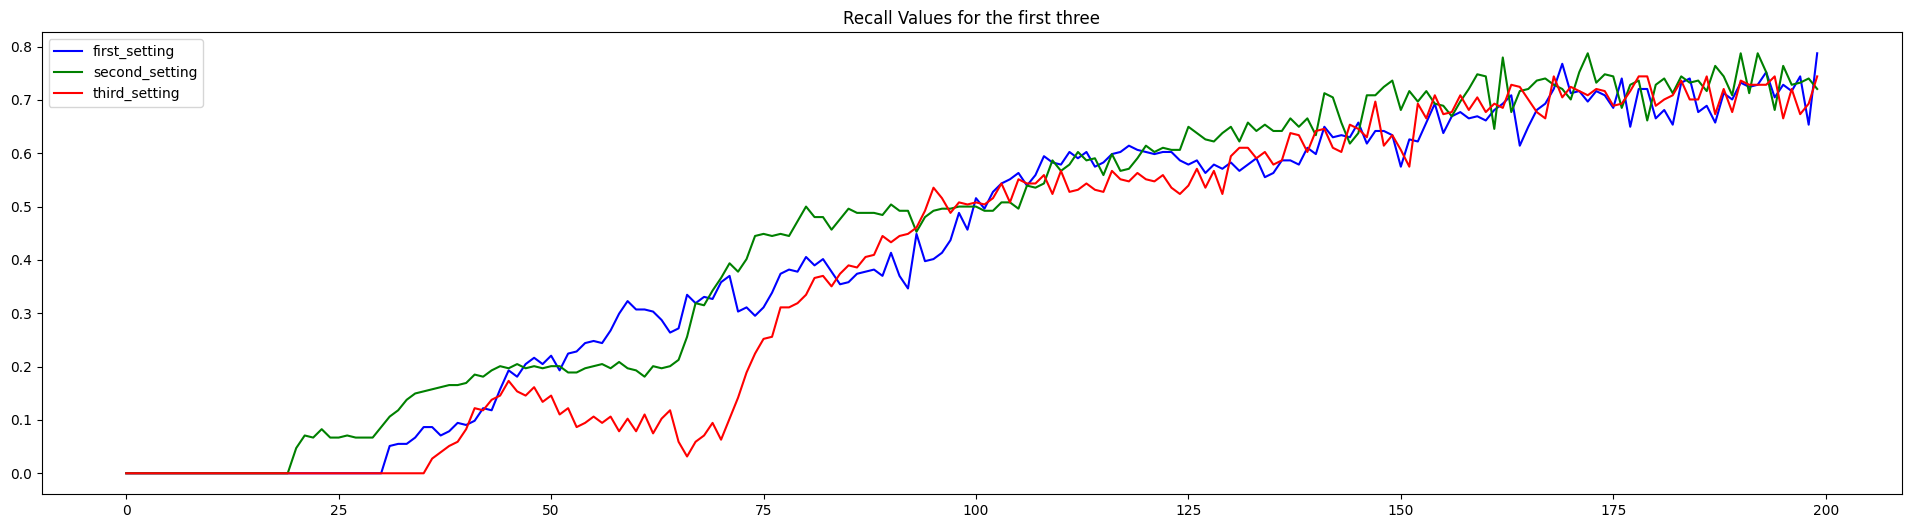

In [199]:
fig, ax = plt.subplots(figsize=(24, 6))


ax.plot(first_setting['epoch'], first_setting['recall'], color='blue', label='first_setting')
ax.plot(second_setting['epoch'], second_setting['recall'], color='green', label='second_setting')
ax.plot(third_setting['epoch'], third_setting['recall'], color='red', label='third_setting')


ax.set_title('Recall Values for the first three')
ax.legend()
plt.show()

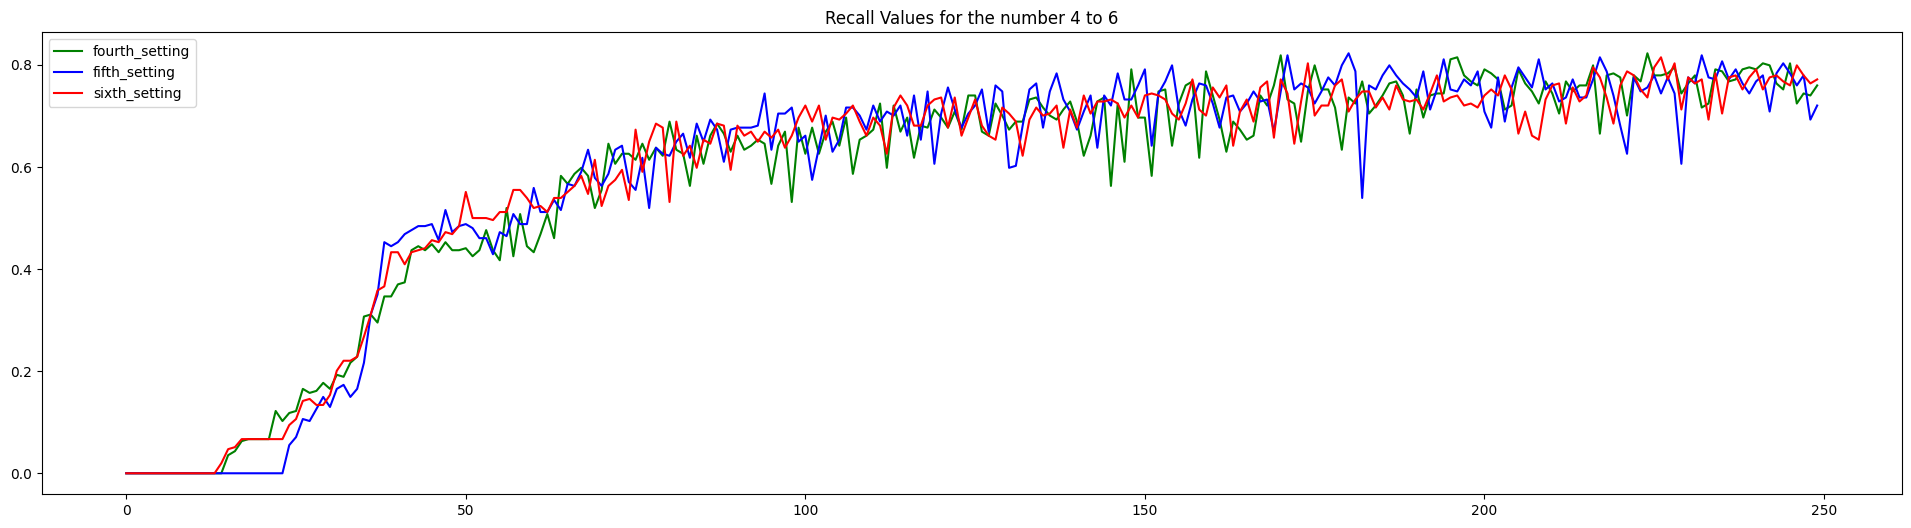

In [203]:
fig, ax = plt.subplots(figsize=(24, 6))

ax.plot(fourth_setting['epoch'], fourth_setting['recall'], color='green', label='fourth_setting')
ax.plot(fifth_setting['epoch'], fifth_setting['recall'], color='blue', label='fifth_setting')
ax.plot(sixth_setting['epoch'], sixth_setting['recall'], color='red', label='sixth_setting')



ax.set_title('Recall Values for the number 4 to 6')
ax.legend()
plt.show()

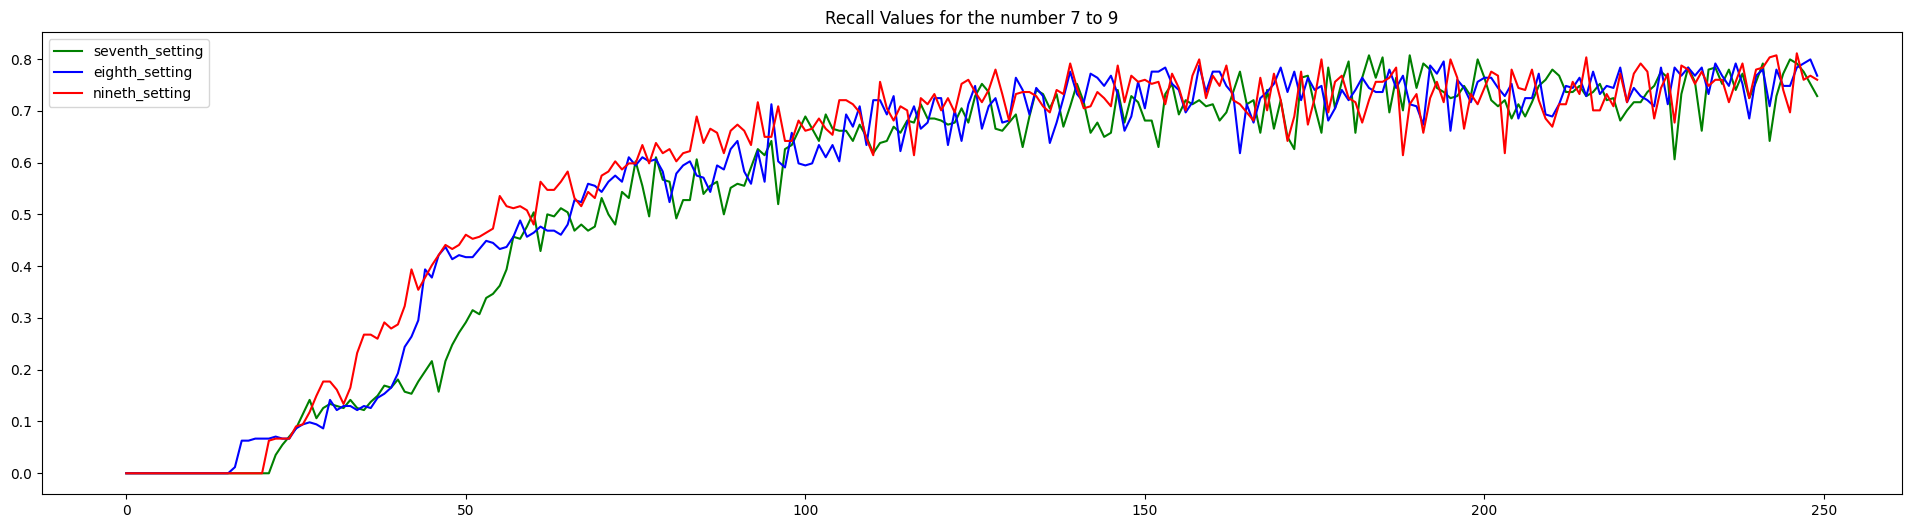

In [201]:
fig, ax = plt.subplots(figsize=(24, 6))

ax.plot(seventh_setting['epoch'], seventh_setting['recall'], color='green', label='seventh_setting')
ax.plot(eighth_setting['epoch'], eighth_setting['recall'], color='blue', label='eighth_setting')
ax.plot(nineth_setting['epoch'], nineth_setting['recall'], color='red', label='nineth_setting')


ax.set_title('Recall Values for the number 7 to 9')
ax.legend()
plt.show()

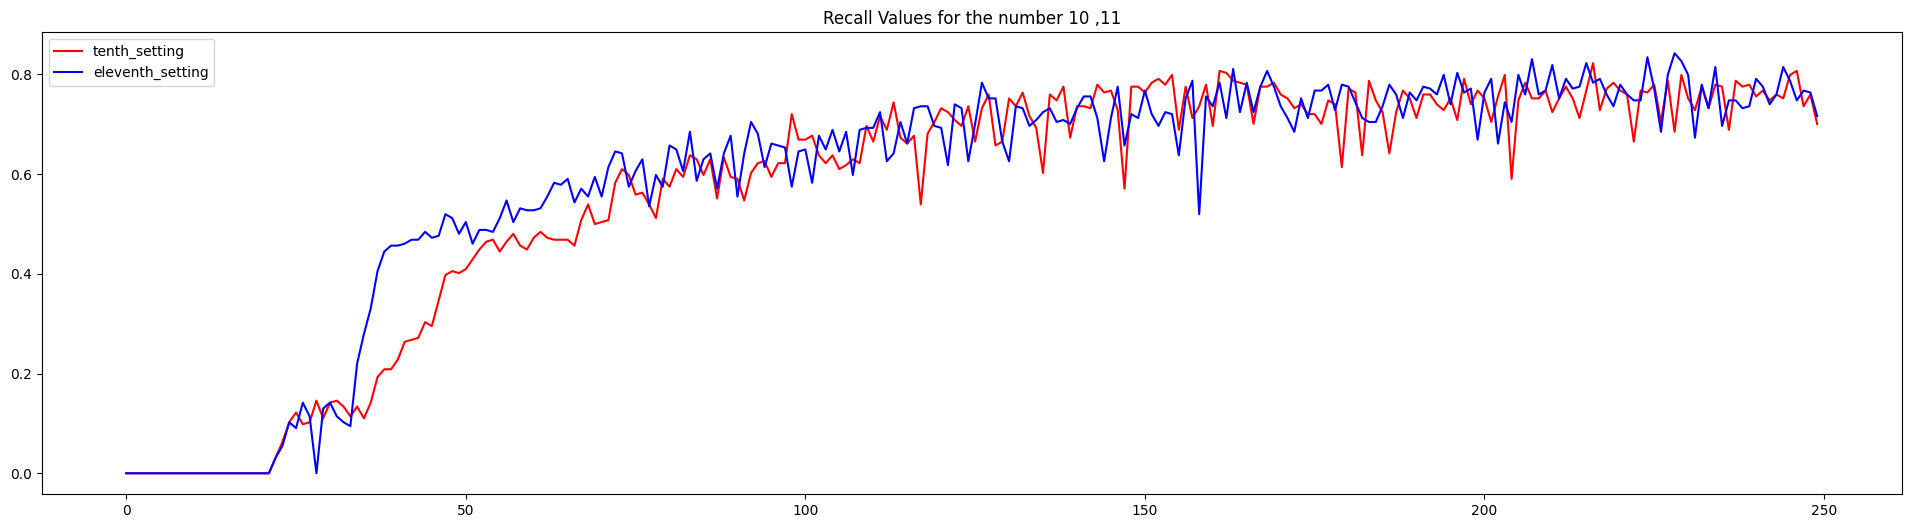

In [204]:
fig, ax = plt.subplots(figsize=(24, 6))

ax.plot(tenth_setting['epoch'], tenth_setting['recall'], color='red', label='tenth_setting')
ax.plot(eleventh_setting['epoch'], eleventh_setting['recall'], color='blue', label='eleventh_setting')

ax.set_title('Recall Values for the number 10 ,11')
ax.legend()
plt.show()